1.环境准备

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

使用设备: cpu


2. 数据加载与检查

In [2]:
# 加载数据
try:
    df = pd.read_csv('trainData.csv', parse_dates=['date'])
    print(" 数据加载成功")
    print(f"数据维度: {df.shape}")
    
    # 显示前3行
    print("\n数据预览:")
    display(df.head(3))
    
    # 检查必要列
    required_cols = ['date', 'price', 'sentiment_score']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"缺少必要列: {missing_cols}")
        
except Exception as e:
    print(f" 数据加载失败: {str(e)}")

 数据加载成功
数据维度: (31016, 8)

数据预览:


,date,price,change_percent,sentiment_score,title,negative,neutral,positive
0,2021-10-12,2280.93,0.00,0.16,"Celo to Be Fastest EVM Chain by End of 2022, C...",0,0,1
1,2021-10-15,2439.72,1.99,0.00,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,0,1,0
2,2021-10-18,2462.15,1.95,0.14,"Facebook To Add 10,000 Jobs In EU For Metavers...",0,0,1


3.数据预处理

In [3]:
# 1. 基础特征
df['returns'] = df['price'].pct_change().shift(1)  # 前一日收益率
df['returns_2'] = df['price'].pct_change(2).shift(1)  # 2日收益率
df['returns_5'] = df['price'].pct_change(5).shift(1)  # 5日收益率

# 2. 波动率特征（严格避免未来信息）
windows = [3,5,10,20]
for w in windows:
    df[f'vol_{w}'] = df['returns'].rolling(w, min_periods=2).std().shift(1)

# 3. 技术指标
df['ma_5'] = df['price'].rolling(5).mean().shift(1)
df['ma_20'] = df['price'].rolling(20).mean().shift(1)
df['ma_ratio'] = df['ma_5'] / df['ma_20']  # 均线比率
df['price_ma5_ratio'] = df['price'] / df['ma_5']  # 价格/MA5比率

# RSI指标
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi_14'] = calculate_rsi(df['price'], 14).shift(1)

# MACD指标
def calculate_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - macd_signal
    return macd.shift(1), macd_signal.shift(1), macd_hist.shift(1)

df['macd'], df['macd_signal'], df['macd_hist'] = calculate_macd(df['price'])

 # 4. 处理极端值
def winsorize(series, limits=[0.05, 0.05]):
    """将数据的上下百分比替换为对应百分位数的值"""
    lower_limit, upper_limit = limits
    lower_bound = series.quantile(lower_limit)
    upper_bound = series.quantile(1 - upper_limit)
    return series.clip(lower=lower_bound, upper=upper_bound)

# 5. 目标变量构造 - 尝试多种目标变量
# 原始目标: 3日对数收益
df['target'] = np.log(df['price'].shift(-3)/df['price'])  

# 二元分类目标: 未来3天价格是否上涨
df['target_binary'] = (df['price'].shift(-3) > df['price']).astype(int)

# 分类目标: 未来收益率区间
def categorize_returns(ret):
    if ret < -0.03:  # 强烈下跌
        return 0
    elif ret < -0.01:  # 下跌
        return 1
    elif ret < 0.01:  # 持平
        return 2
    elif ret < 0.03:  # 上涨
        return 3
    else:  # 强烈上涨
        return 4

df['target_category'] = df['target'].apply(categorize_returns)

df.dropna(inplace=True)

# 6. 特征选择 - 扩展特征集
features = [
    'returns', 'returns_2', 'returns_5', 
    'vol_3', 'vol_5', 'vol_10', 'vol_20', 
    'ma_5', 'ma_20', 'ma_ratio', 'price_ma5_ratio',
    'rsi_14', 'macd', 'macd_hist', 'sentiment_score'
]

# 7. 标准化（时间序列安全版本）
train_size = int(len(df)*0.8)
scaler = StandardScaler()
scaler.fit(df.iloc[:train_size][features])

def safe_transform(data):
    return pd.DataFrame(
        scaler.transform(data[features]),
        index=data.index,
        columns=features
    )

train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()
train_df[features] = safe_transform(train_df)
test_df[features] = safe_transform(test_df)

# 特征重要性分析
from sklearn.ensemble import RandomForestRegressor
X_train = train_df[features]
y_train = train_df['target']

# 拟合一个随机森林来评估特征重要性
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 打印特征重要性
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("特征重要性:\n", feature_importance)

# 检查特征-目标相关性
correlation = train_df[features + ['target']].corr()
print("特征与目标的相关性:\n", correlation['target'].sort_values(ascending=False))



特征重要性:
             Feature  Importance
12             macd    0.211656
8             ma_20    0.174030
13        macd_hist    0.137030
6            vol_20    0.117290
9          ma_ratio    0.102554
7              ma_5    0.085567
14  sentiment_score    0.049342
5            vol_10    0.038055
10  price_ma5_ratio    0.026130
4             vol_5    0.016670
11           rsi_14    0.015268
2         returns_5    0.013159
0           returns    0.005646
1         returns_2    0.003906
3             vol_3    0.003698
特征与目标的相关性:
 target             1.000000
vol_20             0.006064
vol_3             -0.003102
vol_5             -0.003910
macd              -0.007323
vol_10            -0.007747
returns           -0.008271
returns_2         -0.012515
returns_5         -0.012671
sentiment_score   -0.014912
ma_ratio          -0.018699
price_ma5_ratio   -0.019137
rsi_14            -0.022040
macd_hist         -0.035145
ma_20             -0.059941
ma_5              -0.061902
Name: target, dtype:

4.创建特征窗口

In [4]:
# 定义参数
window_size = (-3, 5)  # 事件窗口范围
windows, targets = [], []
features = ['price', 'sentiment_score', 'change_percent']  # 确保这些特征存在于df中

# 找到所有有新闻的日期（假设sentiment_score非零表示有新闻）
event_dates = df[df['sentiment_score'].abs() > 0.01].index

for idx in event_dates:
    start = idx + window_size[0]
    end = idx + window_size[1] + 1
    
    if start >= 0 and end <= len(df):
        try:
            # 提取特征并确保转换为numpy数组
            window_data = df.iloc[start:end][features].values
            
            # 添加时间编码
            time_pos = np.linspace(0, 1, end-start).reshape(-1, 1)
            window_data = np.hstack([window_data, time_pos])
            
            # 计算目标（未来3天平均收益率）
            if end + 3 <= len(df):
                future_window = df.iloc[end:end+3]
                target = future_window['price'].mean() / df.iloc[end-1]['price'] - 1
                
                # 确保数据类型正确
                window_data = np.array(window_data, dtype=np.float32)
                target = np.float32(target)
                
                windows.append(window_data)
                targets.append(target)
        except Exception as e:
            print(f"处理索引 {idx} 时出错: {e}")
            continue

# 转换为numpy数组
windows = np.array(windows)
targets = np.array(targets)

print(f"共创建 {len(windows)} 个事件窗口")
if len(windows) > 0:
    print(f"每个窗口形状: {windows[0].shape}")
    print(f"特征维度: {windows.shape}")
    print(f"目标维度: {targets.shape}")
else:
    print("警告：未创建任何有效的事件窗口")

共创建 2477 个事件窗口
每个窗口形状: (9, 4)
特征维度: (2477, 9, 4)
目标维度: (2477,)


5.创建PyTorch数据集

In [5]:
class CryptoDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.LongTensor(targets)  # 使用LongTensor存储分类目标
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# 数据预处理
# 方案：直接使用百分比变化作为目标变量，不做对数变换
df['target'] = df['change_percent']

# 处理极端值（可选）
# 使用百分位数截断法处理异常值
q_low = df['target'].quantile(0.01)
q_high = df['target'].quantile(0.99)
df['target'] = df['target'].clip(q_low, q_high)

# 选择特征和目标
features = [
    'returns', 'returns_2', 'returns_5', 
    'vol_3', 'vol_5', 'vol_10', 'vol_20', 
    'ma_5', 'ma_20', 'ma_ratio', 'price_ma5_ratio',
    'rsi_14', 'macd', 'macd_hist', 'sentiment_score'
]
X = df[features].values  # 确保转换为numpy数组
y = df['target_category'].values

# 对特征进行标准化处理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


# 划分训练集/测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True,  # 确保数据被打乱
    stratify=y     # 保持各类别比例一致
)

# 创建数据集实例
train_dataset = CryptoDataset(X_train, y_train)
val_dataset = CryptoDataset(X_test, y_test)

# 创建数据加载器
train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    drop_last=True  # 丢弃最后一个不完整的批次
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=64,
    drop_last=True
)
# 验证数据加载是否正确
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx}: inputs shape: {inputs.shape}, targets shape: {targets.shape}")
    if batch_idx == 0:  # 只打印第一个批次
        break

# 打印数据集信息
print(f"\n训练样本: {len(X_train)} | 验证样本: {len(X_test)}")
print("\n目标值统计:")
print(f"训练集: Min={np.min(y_train):.4f}, Max={np.max(y_train):.4f}, Mean={np.mean(y_train):.4f}, Std={np.std(y_train):.4f}")
print(f"验证集: Min={np.min(y_test):.4f}, Max={np.max(y_test):.4f}, Mean={np.mean(y_test):.4f}, Std={np.std(y_test):.4f}")

Batch 0: inputs shape: torch.Size([64, 15]), targets shape: torch.Size([64])

训练样本: 8153 | 验证样本: 2039

目标值统计:
训练集: Min=0.0000, Max=4.0000, Mean=1.9983, Std=0.2780
验证集: Min=0.0000, Max=4.0000, Mean=1.9985, Std=0.2810


6.模型定义

In [6]:
#pip install -i https://mirrors.aliyun.com/pypi/simple/ transformers

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class ImprovedBiLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.2):
        super(ImprovedBiLSTMAttention, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        # 特征投影层
        self.feature_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )
        
        # 双向LSTM
        self.lstm = nn.LSTM(
            hidden_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 自注意力机制
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        # 输出层
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        # 输入形状处理
        if len(x.size()) == 2:
            x = x.unsqueeze(1)
        
        batch_size, seq_len, _ = x.size()
        
        # 特征投影
        x = x.reshape(-1, x.size(-1))
        x = self.feature_projection(x)
        x = x.reshape(batch_size, seq_len, -1)
        
        # LSTM处理
        lstm_out, _ = self.lstm(x)
        
        # 注意力计算
        attention_weights = self.attention(lstm_out)
        attention_weights = F.softmax(attention_weights, dim=1)
        
        # 计算上下文向量
        context = torch.bmm(attention_weights.transpose(1, 2), lstm_out)
        context = context.squeeze(1)
        
        # 分类
        logits = self.classifier(context)
        
        return logits

# 创建改进的模型实例
model = ImprovedBiLSTMAttention(
    input_dim=len(features),
    hidden_dim=128,
    num_layers=2,
    num_classes=5,
    dropout=0.3
).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

# 学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)

# 打印模型结构
print(model)

ImprovedBiLSTMAttention(
  (feature_projection): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=5, bias=True)
  )
)


7.配置训练

In [12]:
criterion = nn.CrossEntropyLoss()
# 修改学习率和学习率调度器
learning_rate = 0.001  # 增大学习率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=10, 
    verbose=True
)

# 定义训练参数
epochs = 100
batch_size = 32
learning_rate = 0.001
early_stopping_patience = 10  # 添加早停参数
best_val_loss = float('inf')
history = {'train': [], 'val': []}
no_improve_count = 0

8.训练循环

In [14]:
# 训练循环
for epoch in range(epochs):
    # 训练阶段
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
        
        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.0 * train_correct / train_total:.2f}%')
    
    # 验证阶段
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
    
    # 计算平均损失和准确率
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_accuracy = 100.0 * train_correct / train_total
    val_accuracy = 100.0 * val_correct / val_total
    
    # 记录历史
    history['train'].append(avg_train_loss)
    history['val'].append(avg_val_loss)
    
    # 打印epoch结果
    print(f'\nEpoch {epoch+1:03d} | '
          f'Train Loss: {avg_train_loss:.4f} | '
          f'Val Loss: {avg_val_loss:.4f} | '
       )
    
    # 更新学习率
    scheduler.step(avg_val_loss)
    
    # 保存最佳模型
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
            'accuracy': val_accuracy
        }, 'best_model.pth')
        no_improve_count = 0
    else:
        no_improve_count += 1
    
    # 早停检查
    if no_improve_count >= early_stopping_patience:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        break

Epoch: 1, Batch: 0, Loss: 0.2173, Acc: 100.00%
Epoch: 1, Batch: 50, Loss: 0.3104, Acc: 96.75%
Epoch: 1, Batch: 100, Loss: 0.1154, Acc: 96.60%

Epoch 001 | Train Loss: 0.2037 | Val Loss: 0.1691 | Train Acc: 96.52% | Val Acc: 96.82%
Epoch: 2, Batch: 0, Loss: 0.2450, Acc: 95.31%
Epoch: 2, Batch: 50, Loss: 0.1789, Acc: 96.63%
Epoch: 2, Batch: 100, Loss: 0.1221, Acc: 96.58%

Epoch 002 | Train Loss: 0.1755 | Val Loss: 0.1603 | Train Acc: 96.59% | Val Acc: 96.82%
Epoch: 3, Batch: 0, Loss: 0.2752, Acc: 95.31%
Epoch: 3, Batch: 50, Loss: 0.2138, Acc: 96.20%
Epoch: 3, Batch: 100, Loss: 0.2079, Acc: 96.53%

Epoch 003 | Train Loss: 0.1644 | Val Loss: 0.1591 | Train Acc: 96.69% | Val Acc: 96.93%
Epoch: 4, Batch: 0, Loss: 0.0332, Acc: 100.00%
Epoch: 4, Batch: 50, Loss: 0.2618, Acc: 96.94%
Epoch: 4, Batch: 100, Loss: 0.2512, Acc: 96.84%

Epoch 004 | Train Loss: 0.1630 | Val Loss: 0.1578 | Train Acc: 96.80% | Val Acc: 96.57%
Epoch: 5, Batch: 0, Loss: 0.1342, Acc: 98.44%
Epoch: 5, Batch: 50, Loss: 0.053

9.训练可视化

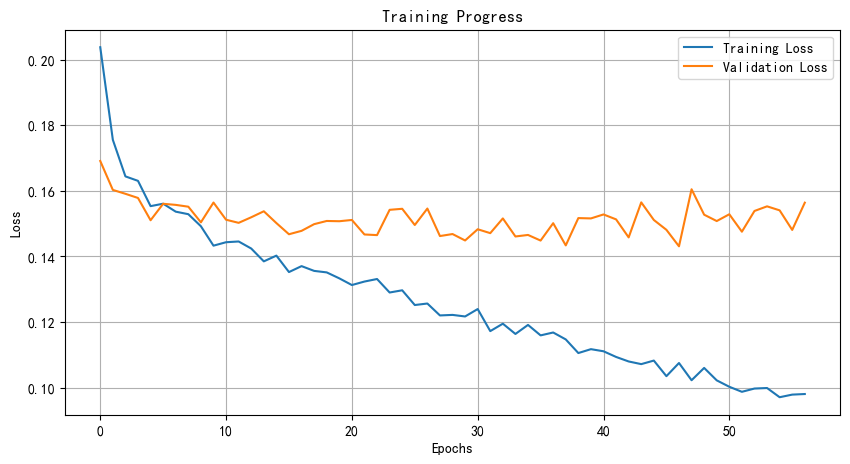

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(history['train'], label='Training Loss')
plt.plot(history['val'], label='Validation Loss')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

10.模型评估


加载最佳模型 (epoch 47, loss 0.1431)

=== 最佳模型评估 ===

训练集结果:
- 样本数量: 8128
- MAE: 0.0802
- 相关系数: 0.6552
- 方向准确率: 98.99%
- 分类准确率: 98.02%

验证集结果:
- 样本数量: 1984
- MAE: 0.1431
- 相关系数: 0.2079
- 方向准确率: 98.39%
- 分类准确率: 96.98%


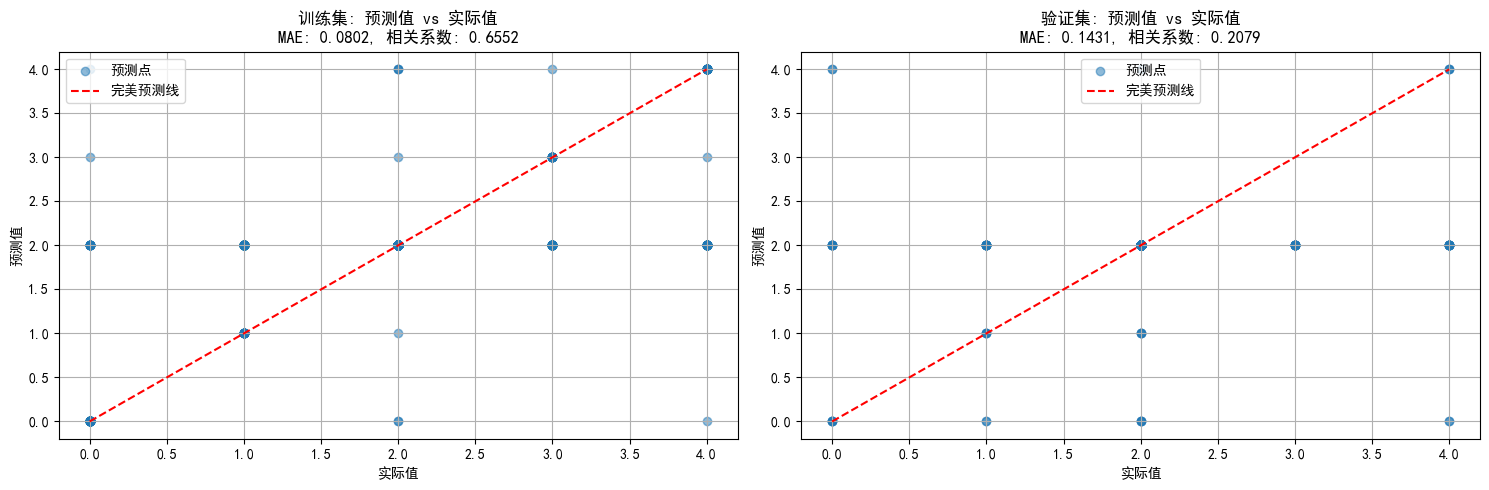


=== 详细统计信息 ===
训练集预测范围: [0.0000, 4.0000]
训练集实际范围: [0.0000, 4.0000]
验证集预测范围: [0.0000, 4.0000]
验证集实际范围: [0.0000, 4.0000]


In [17]:
from sklearn.metrics import mean_absolute_error
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
def evaluate_detailed(model, data_loader, device, name=""):
    """
    详细评估模型性能，包括分类准确率和混淆矩阵
    """
    model.eval()
    all_predictions = []
    all_targets = []
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # 获取模型输出
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # 获取预测类别
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # 收集预测结果
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # 计算评估指标
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)
    
    # 转换为numpy数组
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # 计算相关系数
    corr = np.corrcoef(all_predictions, all_targets)[0, 1] if len(all_predictions) > 1 else 0
    
    # 计算方向准确率
    pred_direction = np.sign(all_predictions - np.mean(all_predictions))
    actual_direction = np.sign(all_targets - np.mean(all_targets))
    direction_accuracy = 100 * np.mean(pred_direction == actual_direction)
    
    # 打印结果
    print(f"\n{name}结果:")
    print(f"- 样本数量: {total}")
    print(f"- MAE: {avg_loss:.4f}")
    print(f"- 相关系数: {corr:.4f}")
    print(f"- 方向准确率: {direction_accuracy:.2f}%")
    print(f"- 分类准确率: {accuracy:.2f}%")
    
    return all_predictions, all_targets, avg_loss, corr, direction_accuracy, accuracy

# 加载最佳模型并评估
try:
    # 加载检查点
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    best_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    print(f"\n加载最佳模型 (epoch {best_epoch+1}, loss {best_loss:.4f})")
    
    # 评估训练集和验证集
    print("\n=== 最佳模型评估 ===")
    train_preds, train_acts, train_mae, train_corr, train_dir_acc, train_class_acc = evaluate_detailed(
    model, train_loader, device, "训练集")

    val_preds, val_acts, val_mae, val_corr, val_dir_acc, val_class_acc = evaluate_detailed(
    model, val_loader, device, "验证集")
    
    # 绘制预测结果
    plt.figure(figsize=(15, 5))
    
    # 训练集预测vs实际值
    plt.subplot(1, 2, 1)
    plt.scatter(train_acts, train_preds, alpha=0.5, label='预测点')
    plt.plot([train_acts.min(), train_acts.max()], 
             [train_acts.min(), train_acts.max()], 
             'r--', label='完美预测线')
    plt.title(f'训练集: 预测值 vs 实际值\nMAE: {train_mae:.4f}, 相关系数: {train_corr:.4f}')
    plt.xlabel('实际值')
    plt.ylabel('预测值')
    plt.legend()
    plt.grid(True)
    
    # 验证集预测vs实际值
    plt.subplot(1, 2, 2)
    plt.scatter(val_acts, val_preds, alpha=0.5, label='预测点')
    plt.plot([val_acts.min(), val_acts.max()], 
             [val_acts.min(), val_acts.max()], 
             'r--', label='完美预测线')
    plt.title(f'验证集: 预测值 vs 实际值\nMAE: {val_mae:.4f}, 相关系数: {val_corr:.4f}')
    plt.xlabel('实际值')
    plt.ylabel('预测值')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 打印详细统计信息
    print("\n=== 详细统计信息 ===")
    print(f"训练集预测范围: [{train_preds.min():.4f}, {train_preds.max():.4f}]")
    print(f"训练集实际范围: [{train_acts.min():.4f}, {train_acts.max():.4f}]")
    print(f"验证集预测范围: [{val_preds.min():.4f}, {val_preds.max():.4f}]")
    print(f"验证集实际范围: [{val_acts.min():.4f}, {val_acts.max():.4f}]")
    
except Exception as e:
    print(f"评估过程中出错: {e}")
    print("\n调试信息:")
    for name, loader in [("训练集", train_loader), ("验证集", val_loader)]:
        total_samples = sum(len(targets) for inputs, targets in loader)
        print(f"{name}样本数: {total_samples}")

11.结果可视化

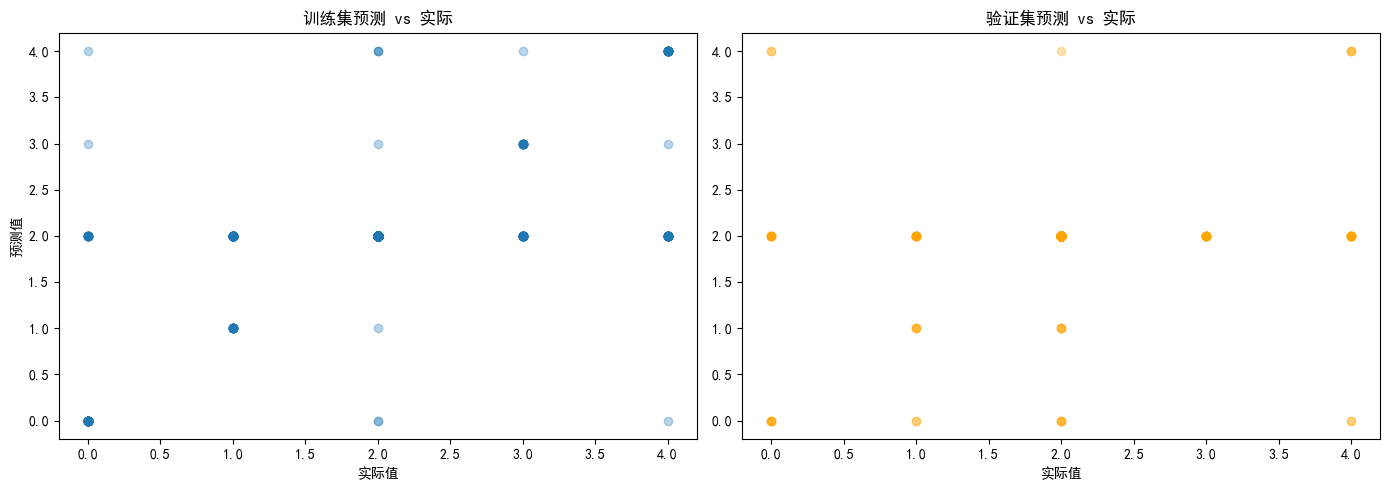

In [18]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_acts, train_preds, alpha=0.3)
plt.title('训练集预测 vs 实际')
plt.xlabel('实际值')
plt.ylabel('预测值')

plt.subplot(1, 2, 2)
plt.scatter(val_acts, val_preds, alpha=0.3, color='orange')
plt.title('验证集预测 vs 实际')
plt.xlabel('实际值')

plt.tight_layout()
plt.show()

12.模型保存

In [19]:
torch.save({
    'model_state': model.state_dict(),
    'input_dim': windows[0].shape[-1],
    'scaler': scaler
}, 'crypto_predictor.pth')

print("模型已保存为 crypto_predictor.pth")

模型已保存为 crypto_predictor.pth
